In [1]:
import pandas as pd
import seaborn as sns
import datetime
from matplotlib import pyplot as plt

In [2]:
dtypes = {"maker": str, "model": str,"mileage": float, "manufacture_year": float,"engine_displacement": float,
"engine_power": float,"body_type": str,"color_slug": str,"stk_year": str,"transmission": str, 
    "door_count": str,"seat_count": str,"fuel_type": str, "date_created": str,"date_last_seen": str, "price_eur": float}

In [3]:
comission_data = pd.read_csv('/home/abhinav/Documents/YUGEN/commission_table.csv')
current_data = pd.read_csv('/home/abhinav/Documents/YUGEN/current_inventory_data.csv',dtype=dtypes)
historical_data = pd.read_csv('/home/abhinav/Documents/YUGEN/historical_data.csv',dtype=dtypes)

# Q1. Which body type has the highest demand in different seasons (Summer, Winter, rainy)?

In [4]:
#Preprocessing Body Type
#For this question we only need Historical data.
historical_data['body_type'] = historical_data['body_type'].str.replace(' ','')
historical_data['body_type'] = historical_data['body_type'].str.replace('com_pact','COMPACT')
historical_data['date_last_seen'] = historical_data['date_last_seen'].str.split(' ').str[0]
historical_data['date_created'] = historical_data['date_created'].str.split(' ').str[0]

In [5]:
historical_data['body_type'].value_counts()

other           379313
nan              61796
compact          43536
coupe            13701
stationwagon     13586
van               6023
offroad           4418
sedan             3713
COMPACT           3074
convertible       1033
transporter        878
Name: body_type, dtype: int64

In [6]:
#here number are 1 - Jan, 2- Feb.. 12 - Dec
winter_months = [11,12,1,2]
summer_months = [3,4,5,6,7]
rainy_months = [8,9,10]

In [7]:
#checking last sold date of car and returning in which season it was sold
def season(row):
    try:
        date_time_str = row['date_last_seen']
        date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')
        month = date_time_obj.month
        if month in winter_months:
            return 'winter'
        elif month in summer_months:
            return 'summer'
        else:
            return 'rainy'
    except:
        return None

In [8]:
historical_data['season'] = historical_data.apply(season,axis=1)

In [9]:
historical_data['season'].value_counts()

summer    336231
winter    325085
rainy      24195
Name: season, dtype: int64

In [10]:
only_sold = historical_data[(historical_data['sold_flag'] == 1)]

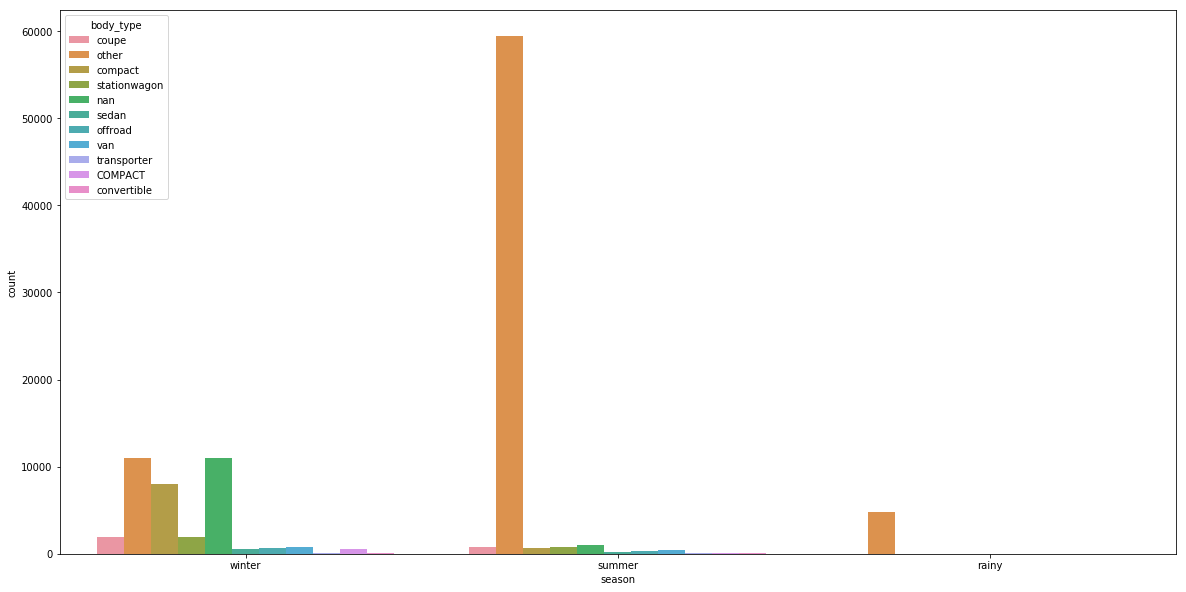

In [11]:
plt.figure(figsize=(20,10))

ax = sns.countplot(x='season',hue='body_type',data=only_sold)


Removing "Other" and "nan" body type from data

In [12]:
only_sold = historical_data[(historical_data['sold_flag'] == 1) & (historical_data['body_type']!='other') & (historical_data['body_type']!='nan')]

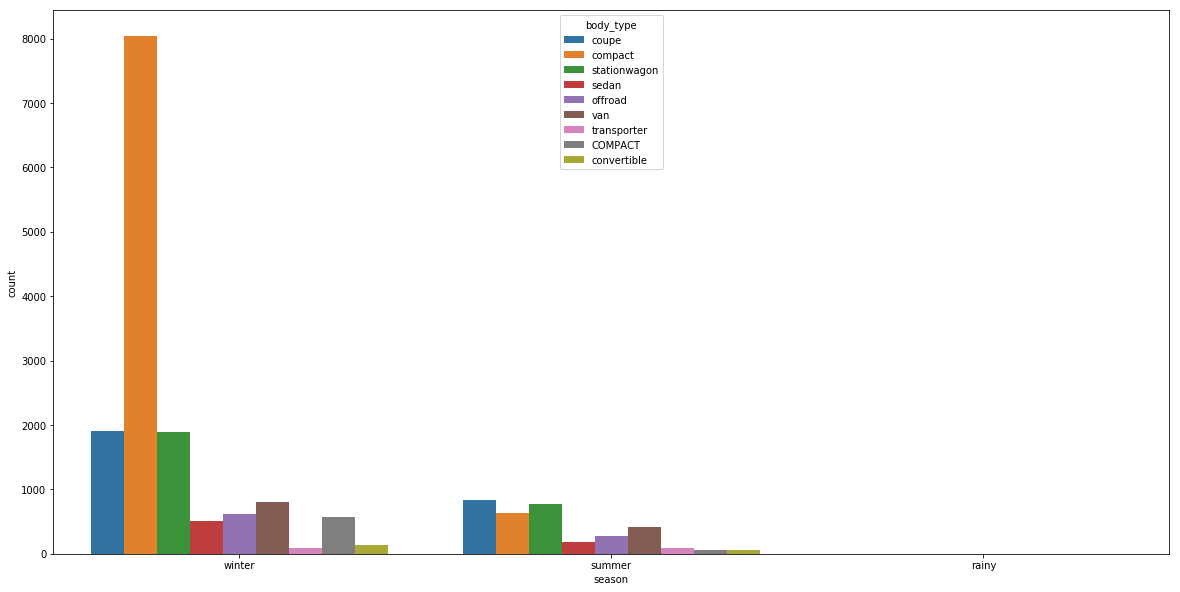

In [13]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='season',hue='body_type',data=only_sold)

Answer - 
1. In winters after maximum "Compact" body type cars were sold, after "Other" body type 
2. In Summers, "Coupe" had highest demand.
3. In Rainy season, only 1 car was sold

# Q2. In the current inventory, how many cars are highly overpriced? Create your own criteria and explain your approach.


Assumption - Overpriced is with respect to a buyer, not the brand of company. If we talk about Porche 911, this car is overpriced when a person buys, but with respect to company, price is fine.

To calculate overprice with respect to brand of company, things get complex, we need to consider Kms driven, Actualy price of car from first hand buyer which is not there is data, is accidental or not, model etc.

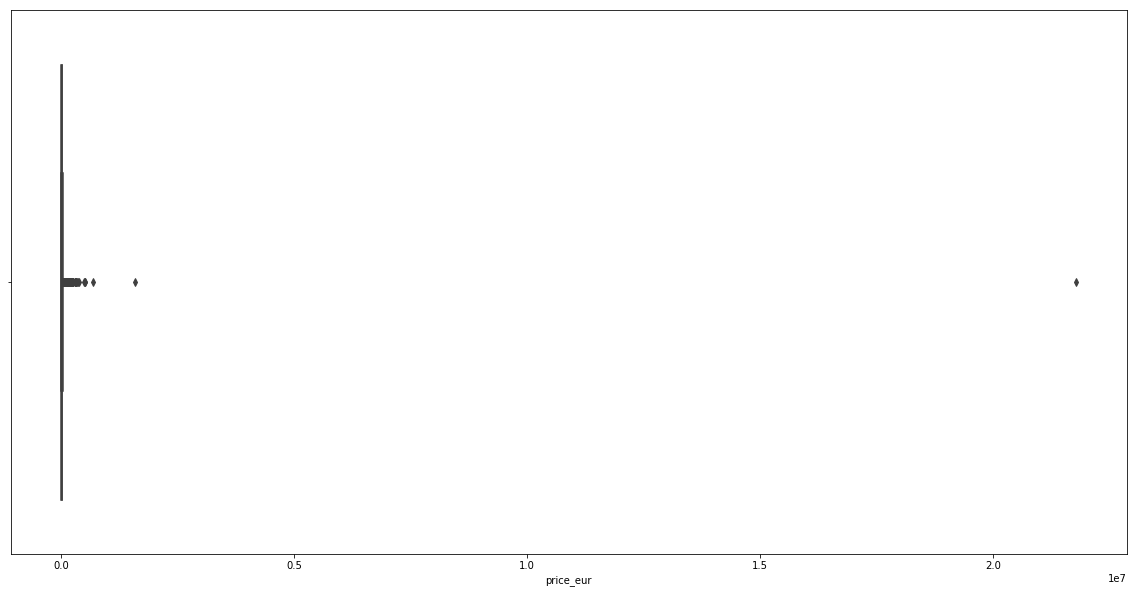

In [14]:
plt.figure(figsize=(20,10))
sns.boxplot(current_data['price_eur'])

There are couple of outliers here which are distorting the mean and variance of "price_eur"

Will be using IQR score, we can use Z-score also

In [15]:
Q1 = current_data['price_eur'].quantile(0.25)
Q3 = current_data['price_eur'].quantile(0.75)

In [16]:
IQR = Q3-Q1

In a normal distrbution graph, Q1 and Q3 hold 25% of data respectively
and in between Q3 and Q1 50% of data data lies, which we also call midspread

Below "over_priced_cars" hold Q1 and Q3 quartile data
"normal_priced" hold middlespread.

We can change standard deviation based on our use case, currently I am using standard number, which is 1.5

In [17]:
over_priced_cars = current_data[((current_data['price_eur'] < (Q1 - 1.5 * IQR)) |(current_data['price_eur'] > (Q3 + 1.5 * IQR)))]
normal_priced = current_data[~((current_data['price_eur'] < (Q1 - 1.5 * IQR)) |(current_data['price_eur'] > (Q3 + 1.5 * IQR)))]

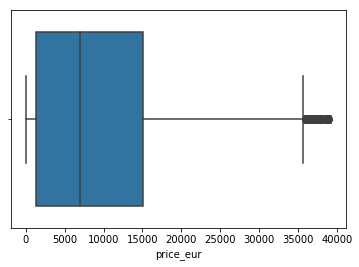

In [18]:
sns.boxplot(normal_priced['price_eur'])

In [19]:
over_priced_cars.shape

(913, 24)

Answer - 
913 cars are overpriced in current inventory

# Q3. Estimate how many new listings we can expect per month on the platform over the next 6 months.


# Q4. How does uploading more photos impact the chance of a car getting sold?

For this we only need historical data, assuming there are cars that can be sold in current inventory data


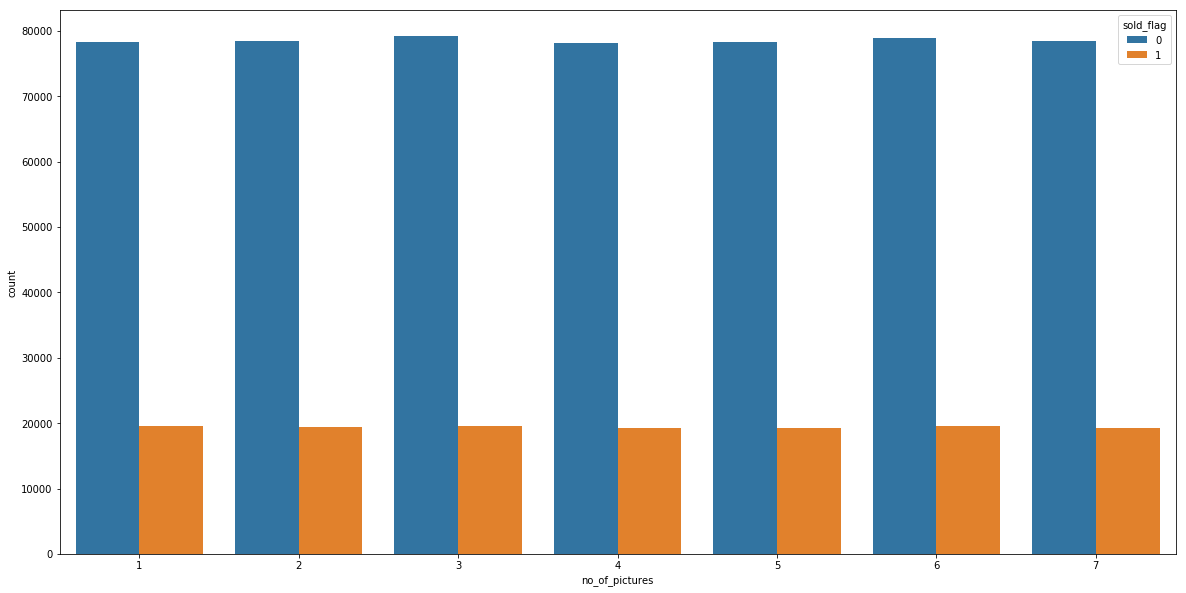

In [20]:
plt.figure(figsize=(20,10))
sns.countplot(x=historical_data['no_of_pictures'],hue=historical_data['sold_flag'])

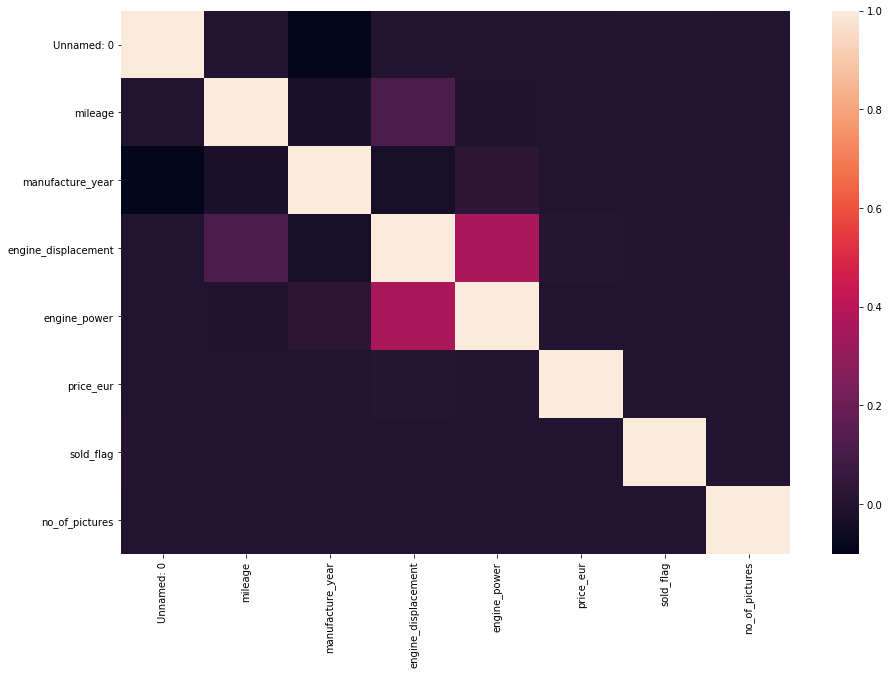

In [21]:
plt.figure(figsize=(15,10))

sns.heatmap(historical_data.corr())

Answer - There isn't any correlation between Number of pictures and getting car sold.

check visual block of "no_of_pictures" and "sold_flag"

# Q5. As a quick win, can you create rule-sets using advertisement heuristics which could be applied to filter out Ads which are bad in quality?


For a bad Ad

1. Missing information of a car
2. Large number of days difference date_created and date_last_seen, this emplies people are not liking this ad or the recommendation engine is not forwarding this ad to people, hence a bad ad.
3. Although cars which are sold already should be removed from current inventory, but those ads does not comes in bad ads.

Fitlering Bad Ads from Historical data

In [22]:
#Adding new column, which hold number of null values in a row

not_sold = historical_data[historical_data['sold_flag'] == 0]
not_sold['null_count'] = not_sold.isnull().sum(axis=1)

/home/abhinav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [23]:
not_sold['null_count'].value_counts()

3     159820
2     109397
4      95390
5      50078
1      35040
6      34984
7      27090
8      19730
9       9273
10      5126
11      1872
0       1190
12       636
Name: null_count, dtype: int64

In [24]:
#Fitlering ads with more than 10 nan values in a row
bad_ads = not_sold[not_sold['null_count'] >= 10]

In [25]:
not_sold = not_sold[~not_sold['season'].isnull()]

In [26]:
#Getting days difference between date last seen and date created, already filtered out ads where sold_flag is 1
not_sold['days_difference'] = abs((pd.to_datetime(not_sold['date_last_seen']) - pd.to_datetime(not_sold['date_created'])).dt.days)

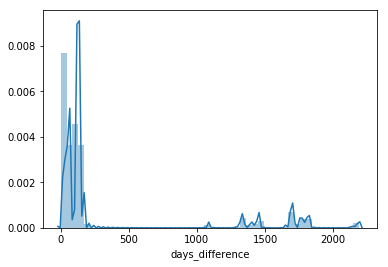

In [27]:
sns.distplot(not_sold['days_difference'])

In [28]:
#Considsering bad ads with dates difference greater than 500
bad_ads_based_on_dates = not_sold[not_sold['days_difference'] > 500]

In [29]:
bad_ads_based_on_dates.shape

(75597, 27)

In [30]:
#Merging both bad ads data
"""
bad_ads - based on null data
bad_ads_based_on_dates - based on date difference between date_created and date_last_seen
"""

'\nbad_ads - based on null data\nbad_ads_based_on_dates - based on date difference between date_created and date_last_seen\n'

In [31]:
bad_ads_final = pd.merge(bad_ads,bad_ads_based_on_dates,how='inner',on='Unnamed: 0')

In [32]:
bad_ads_final.shape

(1054, 52)

Answer - 1054 Bad ads

# Q6. What are the top 3 features that you have created using the columns given in the data? What is your criteria of choosing Top 3 features?


Will be following 3 methods and taking union of these result
1. Feature Engineering
2. Correlation heatmap.
3. Feature importance on Tree based model(works better on categorical values)


## Before feature selection, lets do some feature engineering.

In [33]:
minimum_manufacture_year = 1947

In [34]:
historical_data.describe()

,Unnamed: 0,mileage,manufacture_year,engine_displacement,engine_power,price_eur,sold_flag,no_of_pictures
count,685582.000000,6.156380e+05,618004.000000,542123.000000,578455.000000,6.855820e+05,685582.000000,685582.000000
mean,355351.399666,1.157356e+05,1990.613444,2044.020888,98.498028,4.344587e+06,0.198307,4.000106
std,205158.965137,3.406349e+05,90.254330,1966.525136,48.940934,3.252856e+09,0.398725,1.999587
min,0.000000,0.000000e+00,0.000000,10.000000,1.000000,4.000000e-02,0.000000,1.000000
25%,177637.250000,1.875900e+04,2003.000000,1400.000000,68.000000,1.295340e+03,0.000000,2.000000
50%,355376.500000,8.630850e+04,2009.000000,1798.000000,86.000000,7.309400e+03,0.000000,4.000000
75%,533055.750000,1.580705e+05,2013.000000,1997.000000,110.000000,1.629482e+04,0.000000,6.000000
max,710581.000000,9.999999e+06,2017.000000,32000.000000,999.000000,2.679450e+12,1.000000,7.000000




We can calculate Average of numerical data and mode for string data,values based on Maker and Model.

In [35]:
#handling null Values for Manufacture Year
historical_avg_year = historical_data.loc[historical_data["manufacture_year"] >= minimum_manufacture_year].groupby(["maker", "model"])["manufacture_year"].mean().round().rename("avg_manufacture_year").reset_index()
historical_data = pd.merge(historical_data,historical_avg_year,on=['maker','model'],how='left')
historical_data['manufacture_year'] = historical_data['manufacture_year'].fillna(historical_data['avg_manufacture_year'])

In [36]:
#handling null values for Engine Displacement

historical_avg_engine_displacement = historical_data.groupby(["maker", "model"])["engine_displacement"].mean().round().rename("avg_engine_displacement").reset_index()
historical_data = pd.merge(historical_data,historical_avg_engine_displacement,on=['maker','model'],how='left')
historical_data['engine_displacement'] = historical_data['engine_displacement'].fillna(historical_data['avg_engine_displacement'])

In [37]:
#handling null values for Engine Power

historical_avg_engine_power = historical_data.groupby(["maker", "model"])["engine_power"].mean().round().rename("avg_engine_power").reset_index()
historical_data = pd.merge(historical_data,historical_avg_engine_power,on=['maker','model'],how='left')
historical_data['engine_power'] = historical_data['engine_power'].fillna(historical_avg_engine_power['avg_engine_power'])

In [38]:
#handling null values for Mileage

historical_avg_mileage = historical_data.groupby(["maker", "model"])["mileage"].mean().round().rename("avg_mileage").reset_index()
historical_data = pd.merge(historical_data,historical_avg_mileage,on=['maker','model'],how='left')
historical_data['mileage'] = historical_data['mileage'].fillna(historical_avg_mileage['avg_mileage'])

In [39]:
historical_data['days_difference'] = abs((pd.to_datetime(historical_data['date_last_seen'],errors = 'coerce') - pd.to_datetime(historical_data['date_created'],errors = 'coerce')).dt.days)

Dropping door count, data is quite messed up

In [40]:
historical_data['door_count'].value_counts()

4       217960
5       172582
None     91516
2        59382
3        23249
0         1504
6          248
1           47
7            8
55           1
77           1
49           1
Name: door_count, dtype: int64

For seat_count, Filling null values with 5, usually a car has 5 seats

In [41]:
historical_data['seat_count'] = pd.to_numeric(historical_data['seat_count'],errors='coerce')
historical_data['seat_count'] = historical_data['seat_count'].fillna(historical_data['seat_count'].median())

For body_type, data is quite messed up, maximum data lies under, 'nan' and 'other', will drop this

In [42]:
historical_data['body_type'].value_counts()

other           379313
nan              61796
compact          43536
coupe            13701
stationwagon     13586
van               6023
offroad           4418
sedan             3713
COMPACT           3074
convertible       1033
transporter        878
Name: body_type, dtype: int64

Cant think of anything with color_slug, will be dropping it

fuel_type will be an important feature in selling a car,
although its null count is quite high.

Filling null fuel_Type by fuel_type median

In [43]:
historical_data['fuel_type'] = historical_data['fuel_type'].fillna('gasoline')

In [44]:
# drop features
features_to_drop = ["avg_manufacture_year","avg_engine_displacement","avg_engine_power"
                    ,"door_count", "color_slug", 
                    "stk_year","test1","test2", "date_created", 
                    "date_last_seen","body_type"]

In [45]:
historical_data = historical_data.drop(columns=features_to_drop,axis=1)

In [46]:
#HANDLING LAGGING SPACES IN COLUMNS
historical_data[['aspect_ratio','height_of_picture','width_of_picture']] = historical_data[['aspect_ratio','height_of_picture','width_of_picture']].apply(lambda x: x.str.strip())


# #FILLING aspect_ratio, height_of_picture and width_of_picture with Mean of their respective columns
historical_data['aspect_ratio'] = pd.to_numeric(historical_data['aspect_ratio'].replace('?',str(round(pd.to_numeric(historical_data['aspect_ratio'],errors='coerce').mean(),2))))
historical_data['height_of_picture'] = pd.to_numeric(historical_data['height_of_picture'].replace('?',str(round(pd.to_numeric(historical_data['height_of_picture'],errors='coerce').mean(),2))))
historical_data['width_of_picture'] = pd.to_numeric(historical_data['width_of_picture'].replace('?',str(round(pd.to_numeric(historical_data['width_of_picture'],errors='coerce').mean(),2))))

In [47]:
#Will be considering only those ads which got sold
historical_data = historical_data[historical_data['sold_flag'] == 1]

In [48]:
#CONVERTING ONE HOT ENCODING FOR CATEGORICAL FEATURES
historical_data = pd.concat([historical_data,pd.get_dummies(historical_data['transmission'])],axis=1)
historical_data = historical_data.drop('transmission',axis=1)

In [49]:
#CONVERTING ONE HOT ENCODING FOR CATEGORICAL FEATURES
historical_data = pd.concat([historical_data,pd.get_dummies(historical_data['fuel_type'])],axis=1)
historical_data = historical_data.drop('fuel_type',axis=1)

In [50]:
#CONVERTING ONE HOT ENCODING FOR CATEGORICAL FEATURES
historical_data = pd.concat([historical_data,pd.get_dummies(historical_data['season'])],axis=1)
historical_data = historical_data.drop('season',axis=1)

In [51]:
historical_data = historical_data.dropna()

In [52]:
#INGESTING COMISSION DATA

In [53]:
comission_data = comission_data.rename(columns={'Maker':'maker','Year':'manufacture_year','Commission':'commission'})


In [54]:
pd.merge(historical_data,comission_data,on=['maker','manufacture_year'],how='left')['commission'].isnull().sum(axis=0)

61005

### Ignoring Commission data, maximum null values are there, although we can ingest average 
### of maker and manufacture year, but this might mislead data, as maximum is null

In [55]:
historical_data.shape

(75235, 26)

In [56]:
current_data

,Unnamed: 0,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,...,date_created,date_last_seen,price_eur,sold_flag,height_of_picture,width_of_picture,aspect_ratio,no_of_pictures,test1,test2
0,9040,volkswagen,sharan,194000.0,1900.0,1896.0,85.0,van,blue,NaN,...,2016-12-29 16:02:25.656542+00,2017-02-09 02:10:59.686135+00,1295.34,0,24,120,5,5,2016-12-29 16:02:25.656542+00,2017-02-09 02:10:59.686135+00
1,339499,audi,200,NaN,2007.0,8400.0,NaN,other,NaN,NaN,...,2016-02-12 10:45:29.950636+00,2016-07-03 18:19:20.659466+00,12176.17,0,?,?,?,2,2016-02-12 10:45:29.950636+00,2016-07-03 18:19:20.659466+00
2,408516,skoda,octavia,0.0,2005.0,NaN,55.0,other,NaN,NaN,...,2016-12-05 17:41:06.32795+00,2016-12-18 07:55:35.445992+00,1295.34,1,38,198,5.2105,4,2016-12-05 17:41:06.32795+00,2016-12-18 07:55:35.445992+00
3,193240,mercedes-benz,NaN,6990.0,2014.0,1595.0,90.0,nan,NaN,2017,...,2016-01-26 01:58:34.274634+00,2016-02-11 07:51:10.138757+00,26880.00,0,?,?,?,3,2016-01-26 01:58:34.274634+00,2016-02-11 07:51:10.138757+00
4,409936,volkswagen,golf-sportsvan,0.0,2015.0,1395.0,92.0,other,NaN,NaN,...,2016-03-04 11:30:51.295258+00,2016-07-03 17:33:07.548746+00,26532.27,0,60,468,7.8,3,2016-03-04 11:30:51.295258+00,2016-07-03 17:33:07.548746+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,703323,NaN,NaN,10.0,NaN,1197.0,77.0,NaN,NaN,None,...,2015-12-07 11:16:32.426055+00,2016-01-05 08:23:15.872952+00,13789.64,1,24,30,1.25,2,2015-12-07 11:16:32.426055+00,2016-01-05 08:23:15.872952+00
24996,461722,NaN,NaN,177000.0,2001.0,999.0,37.0,NaN,NaN,None,...,2015-12-02 09:30:43.678255+00,2016-01-05 00:32:58.659485+00,890.08,0,110,108,0.9818,5,2015-12-02 09:30:43.678255+00,2016-01-05 00:32:58.659485+00
24997,613098,hyundai,i30,116375.0,2013.0,1582.0,81.0,other,NaN,NaN,...,2016-10-23 20:04:20.535009+00,2016-12-23 06:00:56.174701+00,1295.34,0,135,126,0.9333,2,2016-10-23 20:04:20.535009+00,2016-12-23 06:00:56.174701+00
24998,145070,audi,200,239000.0,NaN,NaN,120.0,compact,NaN,None,...,2016-01-15 13:23:04.139303+00,2016-01-20 07:42:21.632972+00,2775.35,0,10,600,60,1,2016-01-15 13:23:04.139303+00,2016-01-20 07:42:21.632972+00


In [57]:
historical_data = historical_data.drop(['Unnamed: 0','model','sold_flag'],axis=1)

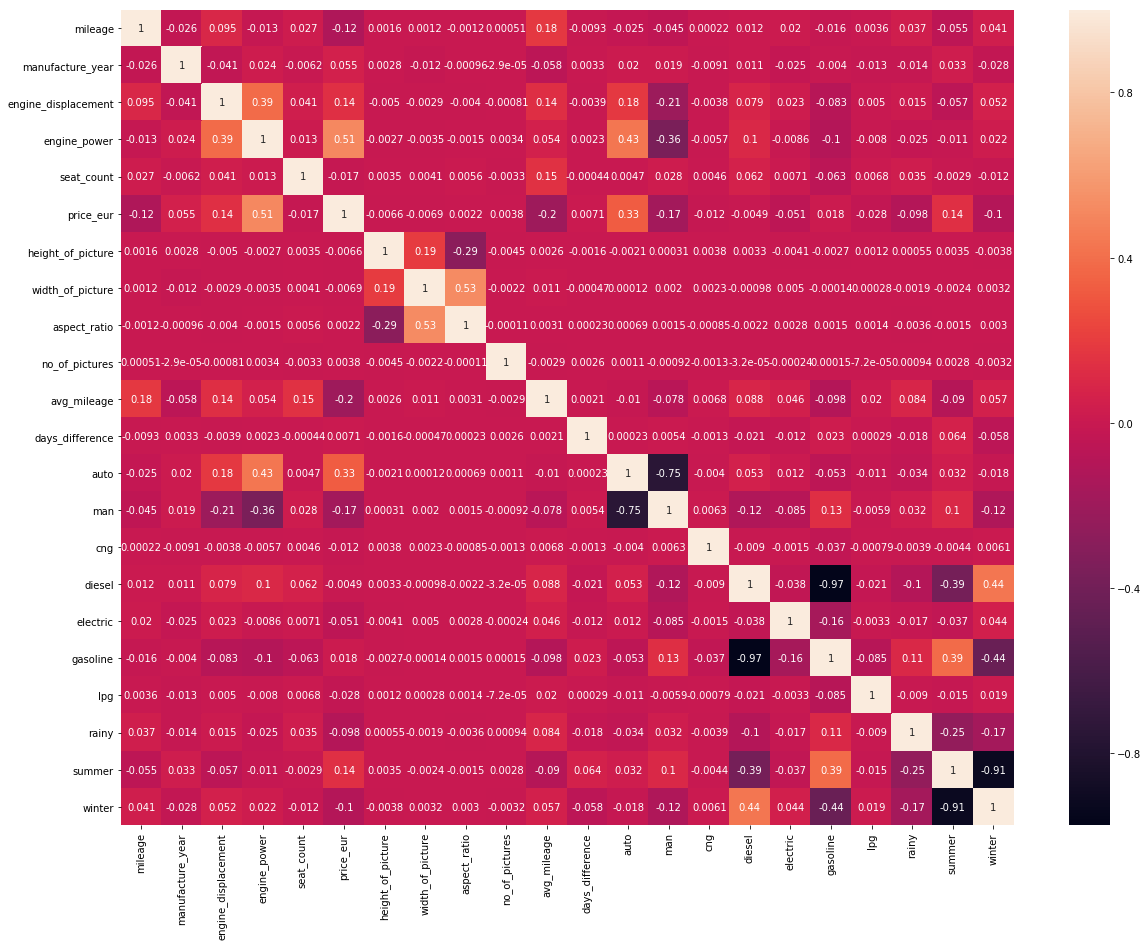

In [58]:
plt.figure(figsize=(20,15))
sns.heatmap(historical_data.corr(),annot=True,)

From Heatmap we get
1. Engine Power
2. Mileage
3. Auto
 
which are highly correlated with price_eur

In [59]:
#CONVERTING ONE HOT ENCODING FOR CATEGORICAL FEATURES
# historical_data = pd.concat([historical_data,pd.get_dummies(historical_data['maker'])],axis=1)
historical_data = historical_data.drop('maker',axis=1)

In [60]:
y = historical_data.pop('price_eur')

In [61]:
X = historical_data

In [62]:
X = X.drop(['aspect_ratio','height_of_picture','width_of_picture'],axis=1)

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [64]:

# decision tree for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot
# define dataset
# define the model
model = DecisionTreeRegressor()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance


In [65]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

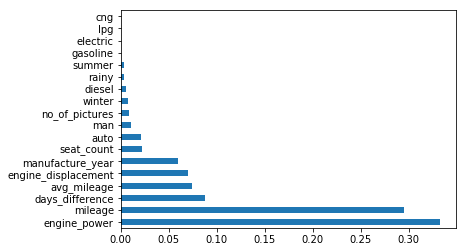

In [66]:
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

Answer - 
Top 3 features
1. Engine Power
2. Mileage
3. Days Difference
4. Engine Displacement
5. Manufacture Year

In [67]:
X.head()

,mileage,manufacture_year,engine_displacement,engine_power,seat_count,no_of_pictures,avg_mileage,days_difference,auto,man,cng,diesel,electric,gasoline,lpg,rainy,summer,winter
0,92000.0,2006.0,1596.0,85.0,5.0,3,138433.0,0.0,0,0,0,0,0,1,0,0,0,1
12,26150.0,2015.0,2967.0,160.0,5.0,4,184518.0,130.0,1,0,0,0,0,1,0,0,1,0
17,10.0,1800.0,1197.0,66.0,5.0,2,96633.0,1337.0,0,1,0,0,0,1,0,0,1,0
19,244322.0,2011.0,2296.0,85.0,5.0,4,168537.0,26.0,0,1,0,0,0,1,0,1,0,0
35,228000.0,2004.0,1998.0,100.0,5.0,7,117005.0,142.0,0,1,0,0,0,1,0,0,1,0


# Q7. Create a Deep Learning Model (using architecture, platform & framework of your choice), to create a ranked list of advertisements in the current inventory which could help the company maximize their revenue.


In [68]:
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout


In [69]:
model = Sequential()
model.add(Dense(20, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=X.shape[1], activation='relu'))

model.add(Dense(1, kernel_initializer='normal',activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])


In [70]:
model.fit(X, y, epochs=10, batch_size=500)


Epoch 1/10
151/151 [==============================] - 12s 995us/step - loss: 318158894.5263 - mean_squared_error: 318158894.5263
Epoch 2/10
151/151 [==============================] - 0s 1ms/step - loss: 279271709.2105 - mean_squared_error: 279271709.2105
Epoch 3/10
151/151 [==============================] - 0s 1ms/step - loss: 226045150.0000 - mean_squared_error: 226045150.0000
Epoch 4/10
151/151 [==============================] - 0s 1ms/step - loss: 206558258.5789 - mean_squared_error: 206558258.5789
Epoch 5/10
151/151 [==============================] - 0s 1ms/step - loss: 201196300.1053 - mean_squared_error: 201196300.1053
Epoch 6/10
151/151 [==============================] - 0s 1ms/step - loss: 170791668.0526 - mean_squared_error: 170791668.0526
Epoch 7/10
151/151 [==============================] - 0s 1ms/step - loss: 182163097.0000 - mean_squared_error: 182163097.0000
Epoch 8/10
151/151 [==============================] - 0s 1ms/step - loss: 181929025.7632 - mean_squared_error: 1819

## Sorry can't spend much time on this, as there are other work in my pipeline to do.

## Thank you.

I am currently running this on historical data, ideally it should run on current inventory data,

For that i have to do whole preprocessing again for current inventory, which I wont be able to do right now.

I am predicting this on historical data for now.

In [80]:
prediction_prices = model.predict(X).flatten()

In [81]:
#Fetching top ads with highest sold price, as data was only trained on sold_flag = 1
top_10_ads = prediction_prices.argsort()[-10:][::-1]

In [82]:
historical_data.iloc[top_10_ads]

,mileage,manufacture_year,engine_displacement,engine_power,seat_count,height_of_picture,width_of_picture,aspect_ratio,no_of_pictures,avg_mileage,...,auto,man,cng,diesel,electric,gasoline,lpg,rainy,summer,winter
54270,4000.0,2002.0,30122.0,93.0,5.0,100.0,155.34,3.9100,7,205250.0,...,0,1,0,1,0,0,0,0,0,1
675142,100.0,2005.0,22000.0,103.0,5.0,43.0,230.00,5.3488,3,186947.0,...,1,0,0,1,0,0,0,0,0,1
190773,100.0,2003.0,32000.0,103.0,5.0,25.0,100.00,4.0000,3,91140.0,...,0,1,0,0,0,1,0,0,1,0
640285,103.0,2004.0,32000.0,103.0,5.0,26.0,133.00,5.1153,5,91140.0,...,0,0,0,0,0,1,0,0,1,0
254354,100.0,2000.0,31900.0,81.0,5.0,64.0,155.34,3.9100,2,91140.0,...,0,0,0,0,0,1,0,0,0,1
81663,100.0,2012.0,31674.0,74.0,5.0,60.0,468.00,7.8000,4,91140.0,...,0,1,0,0,0,1,0,0,0,1
170299,100.0,2006.0,21500.0,92.0,5.0,63.0,150.00,2.3809,5,167498.0,...,0,0,0,0,0,1,0,0,0,1
203626,100.0,2005.0,20100.0,150.0,5.0,64.0,155.34,3.9100,5,170965.0,...,0,1,0,1,0,0,0,0,0,1
569003,23950.0,1997.0,23950.0,96.0,5.0,31.0,88.00,2.8387,4,163243.0,...,0,0,0,0,0,1,0,1,0,0
34499,28000.0,1999.0,31800.0,110.0,5.0,17.0,98.00,5.7647,5,91140.0,...,0,1,0,0,0,1,0,0,0,1
